In [68]:
import pandas as pd
import numpy as np
import nltk
import string
from time import time
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
review_json = 'yelp_dataset/yelp_academic_dataset_review.json'
#
#size = 1000000
#review = pd.read_json(review_json, lines=True,
#                      dtype={'review_id':str,'user_id':str, 'business_id':str,'stars':int, 'date':str,'text':str,'useful':int, 'funny':int,'cool':int}, 
#                      chunksize=size)
#chunk_list = []
#for chunk_review in review:
#    chunk_review = chunk_review.drop(['review_id','user_id', 'business_id', 'date', 'useful','funny','cool'], axis=1)
#    chunk_list.append(chunk_review)
#df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)
#csv_name = "yelp_reviews.csv"
#df.to_csv(csv_name, index=False)

#df = pd.read_csv('yelp_reviews.csv', chunksize = 5000)
#for chunk in df:
#    print(list(chunk.columns.values))

In [16]:
t0 = time()
yelp_df = pd.read_csv('yelp_reviews.csv')
goog_df = pd.read_csv('google_reviews.csv')
load_time = time() - t0
print("Dataframe load time:  %0.3fs" % load_time)

Dataframe load time:  87.742s


In [48]:
#df2 = df.sample(5000)
#df.shape
#print (yelp_df.dtypes)
#print (goog_df.dtypes)
df1 = yelp_df[yelp_df.stars == 1].sample(1000)
df2 = yelp_df[yelp_df.stars == 2].sample(1000)
df3 = yelp_df[yelp_df.stars == 3].sample(1000)
df4 = yelp_df[yelp_df.stars == 4].sample(1000)
df5 = yelp_df[yelp_df.stars == 5].sample(1000)
df6 = goog_df[goog_df.stars == 1].sample(1000)
df7 = goog_df[goog_df.stars == 2].sample(1000)
df8 = goog_df[goog_df.stars == 3].sample(1000)
df9 = goog_df[goog_df.stars == 4].sample(1000)
df10 = goog_df[goog_df.stars == 5].sample(1000)
yelp_samples = [df1, df2, df3, df4, df5]
goog_samples = [df6, df7, df8, df9, df10]
yelp_df = pd.concat(yelp_samples)
goog_df = pd.concat(goog_samples)
yelp_x = yelp_df['text']
yelp_y = yelp_df['stars']
goog_x = goog_df['text']
goog_y = goog_df['stars']
goog_x_train,x_test,goog_y_train,y_test = train_test_split(goog_x,goog_y,test_size=0.2)
x_train = pd.concat([yelp_x, goog_x_train])
y_train = pd.concat([yelp_y, goog_y_train])

In [78]:
def cleantext(text):
    nopunc = [w for w in word_tokenize(text) if w not in string.punctuation]
    return [word for word in nopunc if word.lower() not in stopwords.words('english')]
t0 = time()
vectorizer = CountVectorizer(analyzer = cleantext)
#tf_vectorizer = TfidVectorizer(analyzer = cleantext, stopwords = 'english') 
x_train_tf = vectorizer.fit_transform(x_train)
print(x_train_tf.shape)
fit_time = time() - t0
print("Vectorizer fit time:  %0.3fs" % fit_time)

(9000, 29648)
Vectorizer fit time:  244.065s


In [79]:
t0 = time()
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(x_train_tf, y_train)
train_time = time() - t0
print("Classifier fit time:  %0.3fs" % train_time)

Classifier fit time:  0.152s


In [80]:
x_test_tf = vectorizer.transform(x_test)
y_prediction = naive_bayes_classifier.predict(x_test_tf)
accuracy = metrics.accuracy_score(y_test, y_prediction)
print("Testing set accuracy:",accuracy)
print("Macro f1 score:", f1_score(y_test,y_prediction,average='macro'))
print("Weighted f1 score:",f1_score(y_test,y_prediction,average='weighted'))

Testing set accuracy: 0.475
Macro f1 score: 0.47494923950980483
Weighted f1 score: 0.4803984222817878


In [81]:
mean_ab_error = mean_absolute_error(y_test, y_prediction)
mean_sq_error = mean_squared_error(y_test, y_prediction)
expl_var_score = explained_variance_score(y_test, y_prediction)
print("Mean absolute error:",mean_ab_error)
print("Mean squared error:", mean_sq_error)
print("Explained variance score:",expl_var_score)

Mean absolute error: 0.702
Mean squared error: 1.166
Explained variance score: 0.43310335643546927


Text(33.0, 0.5, 'predicted label')

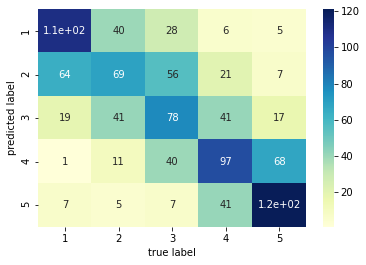

In [83]:
mat = confusion_matrix(y_test, y_prediction)
#print(mat)
categories = ['1','2','3','4','5']
sns.heatmap(mat.T, annot=True,  xticklabels=categories,yticklabels=categories, cmap="YlGnBu")
plt.xlabel('true label')
plt.ylabel('predicted label')

In [88]:
'''
Example code to use model on a specific business scraped and compare 
'''
business_reviews = 'business_reviews.csv'
business_df = pd.read_csv(business_reviews)
business_text = business_df['text']
business_stars = business_df['stars']
business_text_vectorized = vectorizer.transform(business_text)
business_prediction = naive_bayes_classifier.predict(business_text_vectorized)
predicted_rating = sum(business_prediction) / len(business_prediction)
actual_rating = sum(business_stars) / len(business_stars)
print("Actual rating from text reviews: ", actual_rating)
print("Predicted rating from text reviews: ", predicted_rating)

Actual rating from text reviews:  4.611111111111111
Predicted rating from text reviews:  4.292929292929293
